# Gradients with Value Class and Torch

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#!conda install -c anaconda graphviz -y
from graphviz import Digraph

## 1. Value Class

### 1.1 Value Class Decleration

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        # Gradient
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data + other.data, _children=(self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        neg = self * -1
        neg.label = f"-{self.label}"
        return neg
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data * other.data, _children=(self, other), _op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporitng int/float powers for now"
        out = Value(data=self.data**other, _children=(self, ), _op=f"**{other}", label=f"{self.label}**{other}")
        
        def _backward():
            self.grad += (other*self.data**(other - 1)) * out.grad
            
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    
    def tanh(self):
        _tanh = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(data=_tanh, _children=(self, ), _op='tanh')
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        _exp = math.exp(self.data)
        out = Value(data=_exp, _children=(self, ), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    @staticmethod
    def trace(root):
        nodes, edges = set(), set()

        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)

        build(root)
        return nodes, edges


    def draw_dot(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

        nodes, edges = self.trace(self)
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
            if n._op:
                dot.node(name=uid+n._op, label=n._op)
                dot.edge(uid+n._op, uid)

        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

        return dot
    
    @staticmethod
    def get_topological_sort(o):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)
        return topo
    
    def backward(self):
        topo = self.get_topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

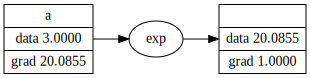

In [4]:
a = Value(3.0, label='a')

b = a.exp()
b.backward()

b.draw_dot()

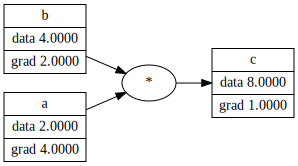

In [5]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

c = a*b; c.label='c'
c.backward()
c.draw_dot()

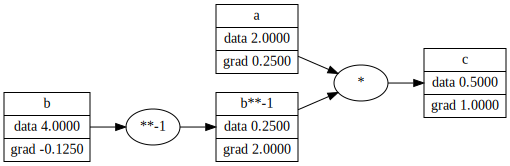

In [6]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

c = a/b; c.label='c'
c.backward()
c.draw_dot()

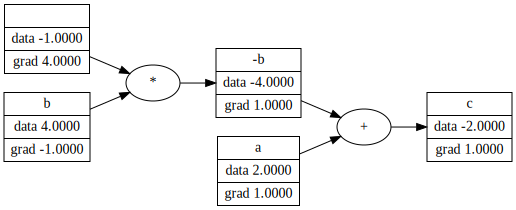

In [7]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

c = a - b; c.label='c'
c.backward()
c.draw_dot()

### 1.2 Bakcward NN

In [8]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label='n'

# activation
o = n.tanh(); o.label='o'

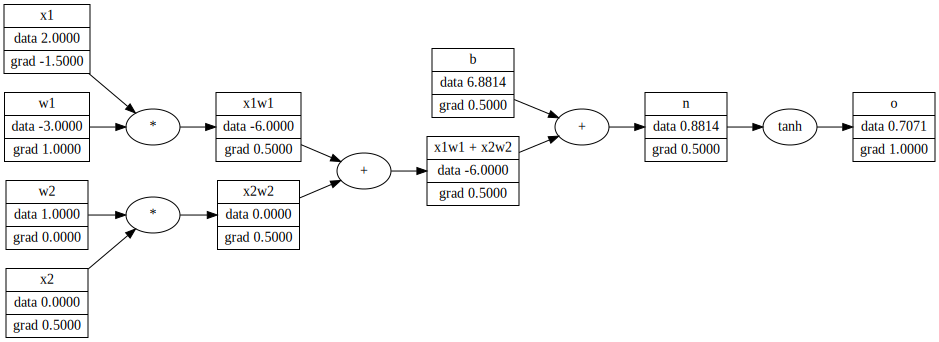

In [9]:
o.backward()
o.draw_dot()

#### 1.2.1 Breaking Tanh using exp

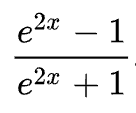

In [10]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label='n'

# activation
#o = n.tanh(); o.label='o'
o = ( (2*n).exp() - 1 ) / ( (2*n).exp() + 1 ); o.label='o'

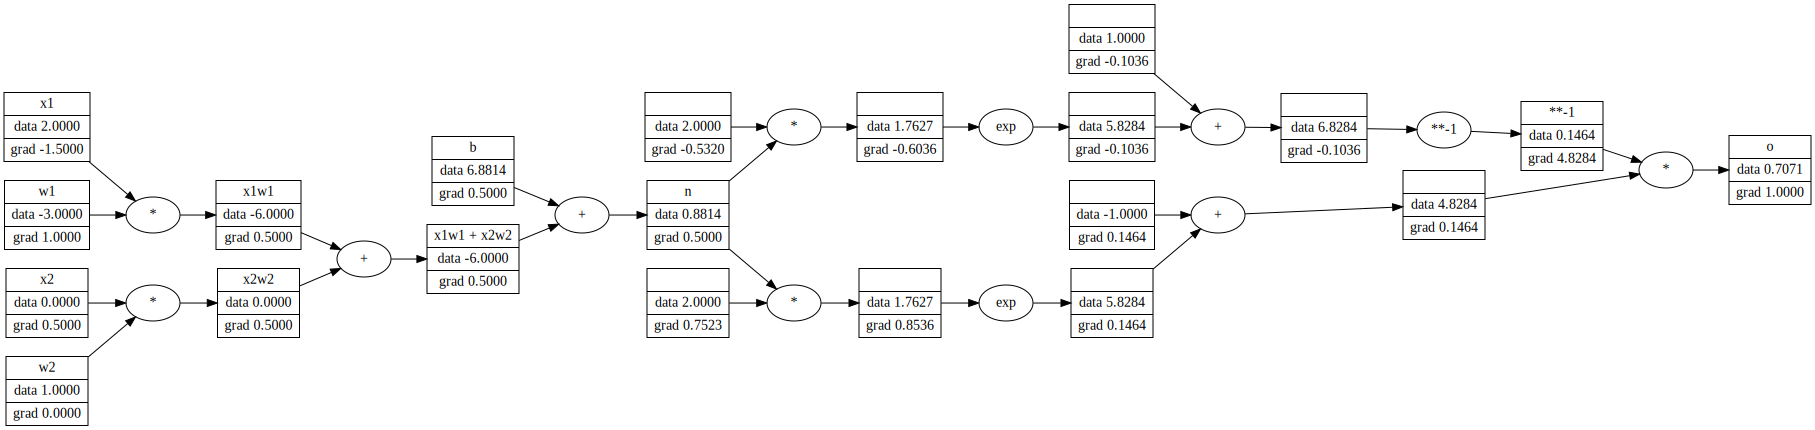

In [11]:
o.backward()
o.draw_dot()

## 2. Torch

In [12]:
import torch

In [13]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [14]:
o.backward(retain_graph=True)

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## 3. NN using Value Class

In [15]:
import random

In [32]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # Forward
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [33]:
x = [2.0, 3.0]
my_neuron = Neuron(2)
my_neuron(x)

Value(data=-0.4512608550815179)

In [34]:
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
       
    def parameters(self):
        return [
            params
            for neuron in self.neurons
            for params in neuron.parameters()
        ]

In [35]:
x = [2.0, 3.0]
my_layer = Layer(2, 3)
my_layer(x)

[Value(data=-0.5522970259902183),
 Value(data=-0.13575998673077103),
 Value(data=-0.8912359386353718)]

In [37]:
class MLP:
    
    def __init__(self, nin, nouts):
        self.layers = [Layer(_nin, _nout) for _nin, _nout in zip([nin]+nouts[:-1], nouts)]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [
            params
            for layer in self.layers
            for params in layer.parameters()
        ]

In [38]:
x = [2.0, 3.0, -1.0]
my_mlp = MLP(3, [4, 4, 1])
o = my_mlp(x)
o

Value(data=-0.8905598513958084)

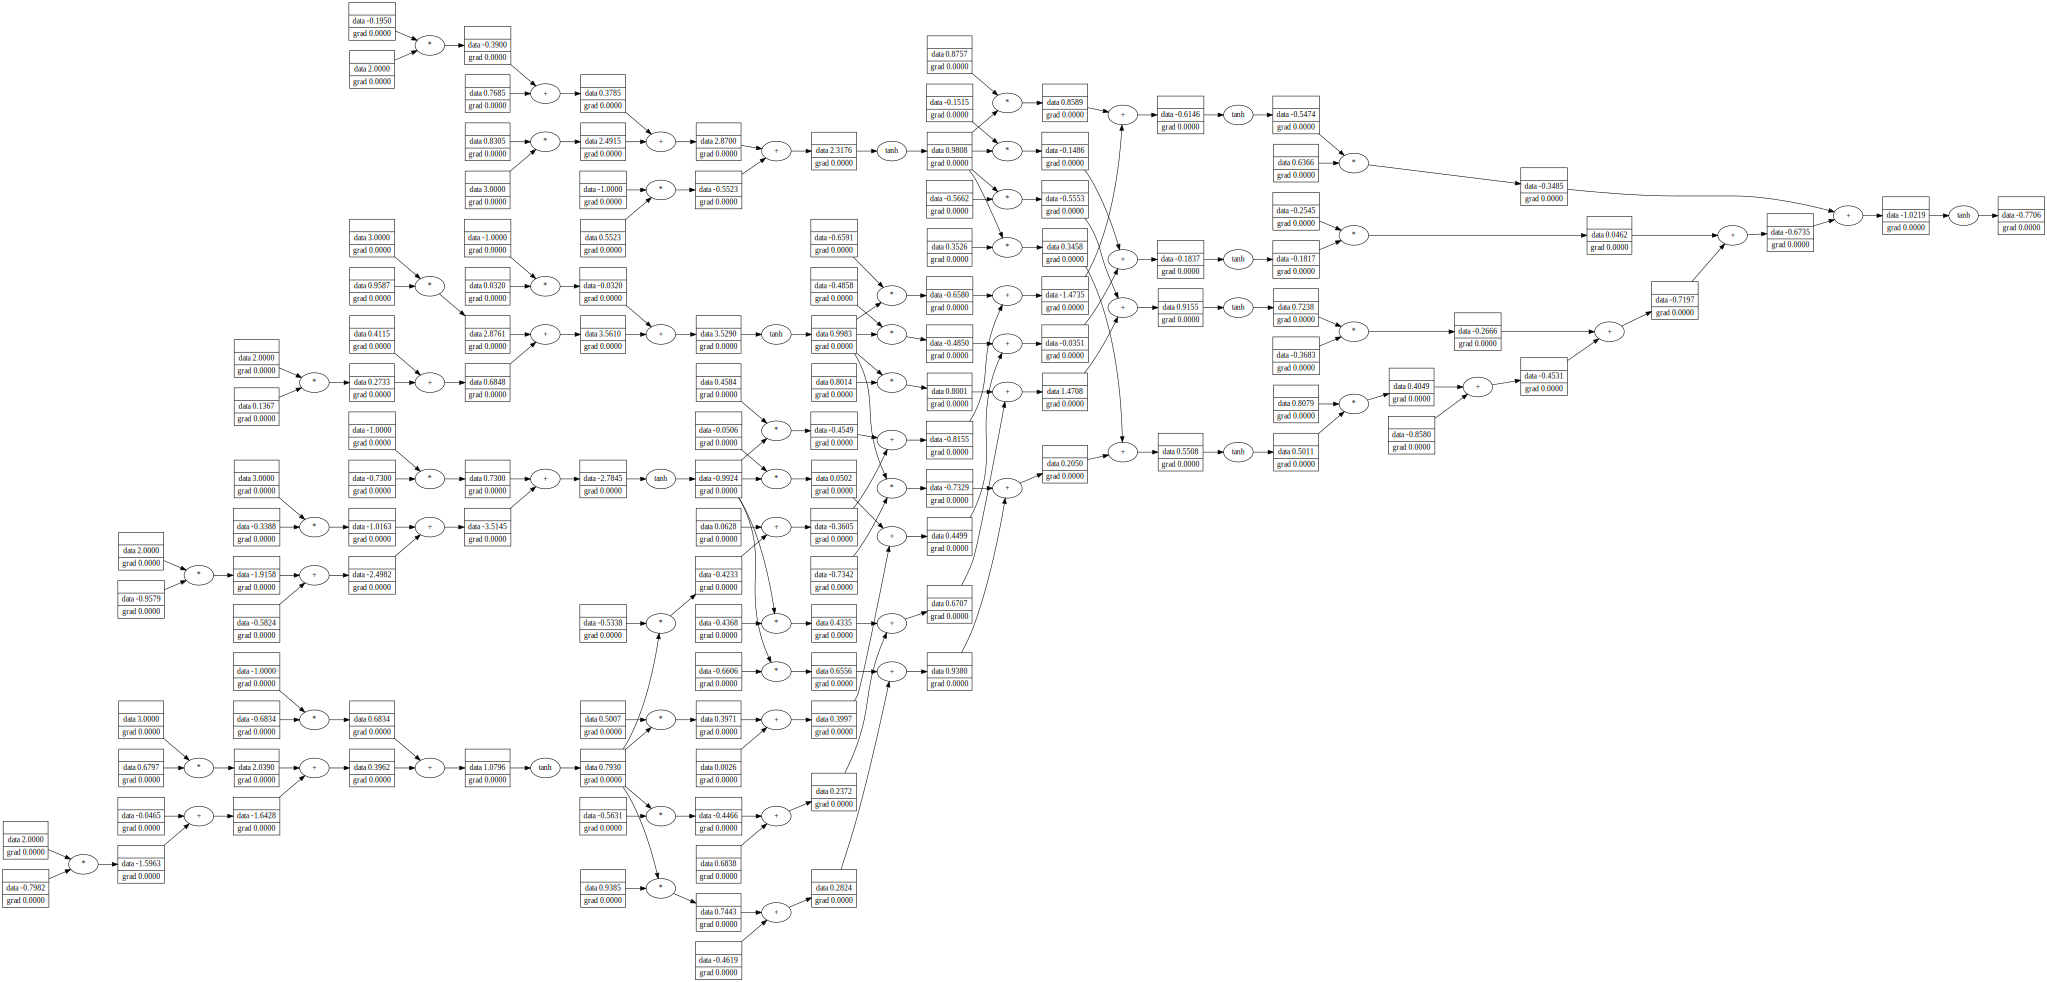

In [22]:
o.draw_dot()

### 3.1 MLP backward

In [39]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [40]:
mlp = MLP(3, [4, 4, 1])

y_preds = [mlp(x) for x in xs]
y_preds

[Value(data=0.9306419440324589),
 Value(data=0.13706624673656784),
 Value(data=0.9660547624630967),
 Value(data=0.8804661389711348)]

In [41]:
## Loss

def mse(y_pred, y_true):
    return sum([(_ypred-_ytrue)**2 for _ypred, _ytrue in zip(y_pred, y_true)])

In [42]:
loss = mse(y_preds, ys)
loss

Value(data=5.1773898623314745)

In [43]:
loss.backward()

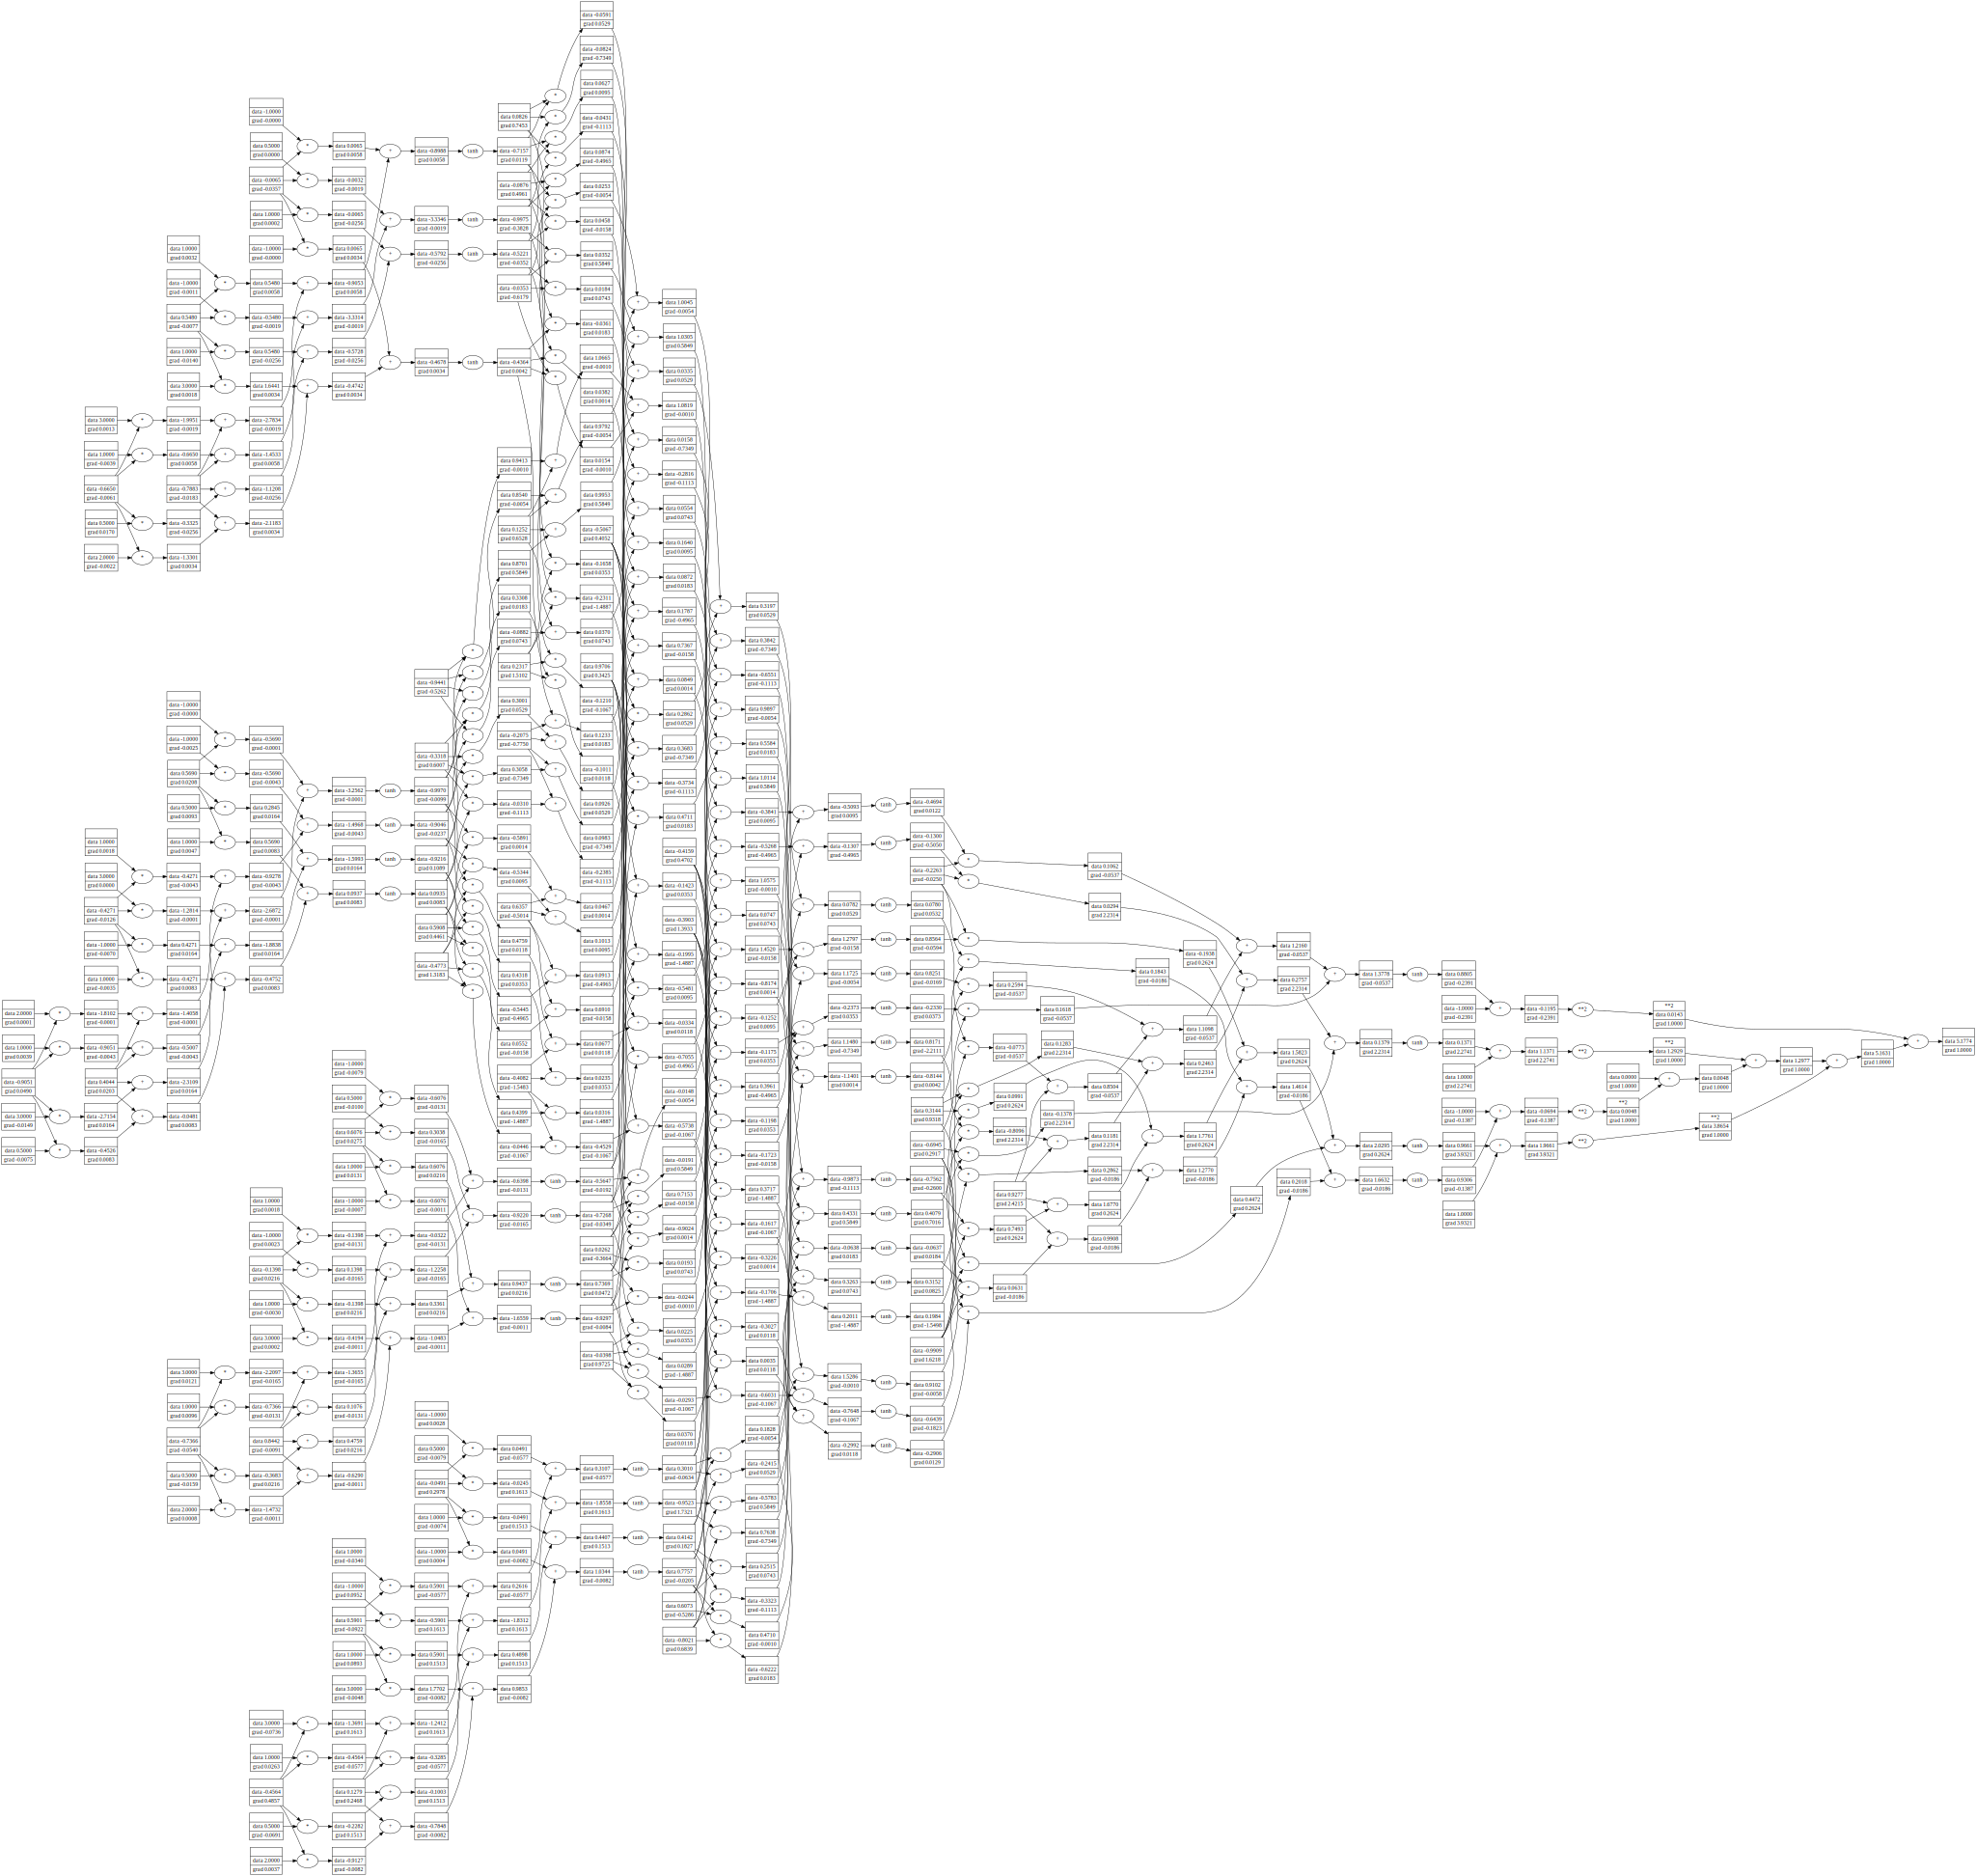

In [44]:
loss.draw_dot()

In [51]:
# Number of parameters:

len(mlp.parameters())

41

In [50]:
loss

Value(data=5.1773898623314745)

In [55]:
mlp.layers[0].neurons[0].w[0].grad

0.048961837785521906

In [56]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [57]:
mlp.layers[0].neurons[0].w[0]

Value(data=-0.9056132980561963)

In [59]:
y_preds = [mlp(x) for x in xs]
print(y_preds)
loss = mse(y_preds, ys)
loss

[Value(data=0.920234987079748), Value(data=0.0319605730215395), Value(data=0.9643843967129085), Value(data=0.8598172360425349)]


Value(data=4.949762346917004)

### 3.2 Complete loop

In [60]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [98]:
lr = 0.05
epochs = 100

In [99]:
mlp = mlp = MLP(3, [4, 4, 1])

print(f"Number of params: {len(mlp.parameters())}")

Number of params: 41


Loss : Value(data=0.007311679823349478)


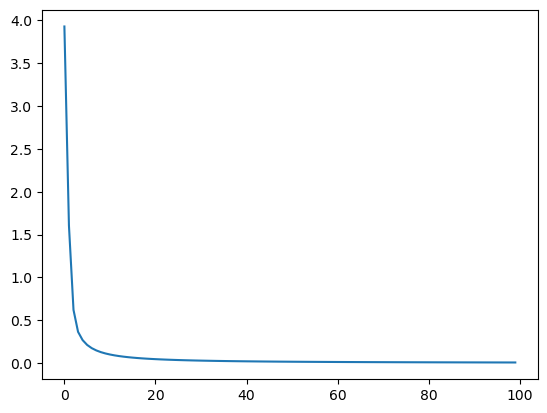

In [100]:
losses = list()

for _ in range(epochs):

    # forward
    y_preds = [mlp(x) for x in xs]
    
    # loss
    loss = mse(y_preds, ys)
    losses.append(loss)
    
    # Zero Grad
    for p in mlp.parameters():
        p.grad = 0.0
        
    # backward
    loss.backward()
    
    # update
    for p in mlp.parameters():
        p.data += -lr*p.grad

plt.plot(range(epochs), list(map(lambda x: x.data, losses)))
print(f"Loss : {losses[-1]}")

In [101]:
y_preds

[Value(data=0.9626759155575669),
 Value(data=-0.9438298479839925),
 Value(data=-0.9805906635225411),
 Value(data=0.9511452742931966)]